<a href="https://colab.research.google.com/github/bootstrap666/compressiveSensingPianoBasis/blob/main/CompSensingPianoBasisMary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import numpy as np
from scipy import sparse
import soundfile as sfile
from IPython.display import Audio
import time
from scipy.optimize import minimize

In [20]:
## This file generates a basis from piano note frequencies (plus a few
# more). We will use this as the basis for our songs during l1-minimization routines.

fs=44100           # Sampling frequency
t = np.arange(1/fs,0.25,1/fs) # Time points of each sample in a quarter-second note
T = len(t)      # Number of samples in a note
M = 29             # Number of notes in Mary Had a Little Lamb.

# The frequencies for piano notes can be derived from formula.
# I simply downloaded them from Professor Bryan Suits at Michigan Tech.
# http://www.phy.mtu.edu/~suits/notefreqs.html

allfreqs = np.array([16.35, 17.32, 18.35, 19.45, 20.6, 21.83, 23.12, 24.5, \
                     25.96, 27.5, 29.14, 30.87, 32.7, 34.65, 36.71, 38.89, \
                     41.2, 43.65, 46.25, 49, 51.91, 55, 58.27, 61.74, 65.41, \
                     69.3, 73.42, 77.78, 82.41, 87.31, 92.5, 98, 103.83, \
                     110, 116.54, 123.47, 130.81, 138.59, 146.83, 155.56, \
                     164.81, 174.61, 185, 196, 207.65, 220, 233.08, 246.94, \
                     261.63, 277.18, 293.66, 311.13, 329.63, 349.23, 369.99, \
                     392, 415.3, 440, 466.16, 493.88, 523.25, 554.37, 587.33, 
                     622.25, 659.26, 698.46, 739.99, 783.99, 830.61, 880, \
                     932.33, 987.77, 1046.5, 1108.73, 1174.66, 1244.51, \
                     1318.51, 1396.91, 1479.98, 1567.98, 1661.22, 1760, \
                     1864.66, 1975.53, 2093, 2217.46, 2349.32, 2489.02, \
                     2637.02, 2793.83, 2959.96, 3135.96, 3322.44, 3520, \
                     3729.31, 3951.07, 4186.01, 4434.92, 4698.64, 4978.03])



In [21]:
## First let's generate the scale so we can hear what the notes will sound
# like.

xall=np.zeros((len(t),len(allfreqs))) # This vector will hold all our notes.

# I multiply the sine waves by exponentials to get a "ding" sound:
df = 15 # This is the rate of decay of the note.
sf = 15 # This is the rate of growth at the beginning of the note.

for i in range(len(allfreqs)):
    xall[:,i] = (1+np.exp(-df*t[len(t)-1])-np.exp(-sf*t))*np.exp(-df*t)*np.sin(2*np.pi*allfreqs[i]*t)


# Play the whole scale to hear what it sounds like:
x=np.zeros(len(t)*len(allfreqs)) # This vector will hold all our notes.

for i in range(len(allfreqs)):
  x[i*len(t):(i+1)*len(t)] = xall[:,i]

#Audio(x,rate=fs)

In [22]:
## Now let's create a basis that we will use to reconstruct songs.
# All notes will be a quarter-second long, and our basis will handle 
# 29-note songs. So we simply need to replicate each note in each position 
# in the song.

# Since there will be a lot of zeros, we will use the sparse matrix format 
# for efficient computation.

I=np.zeros(len(t)*len(allfreqs)*M) # Row indices
J=np.zeros(len(t)*len(allfreqs)*M) # Column indices
S=np.zeros(len(t)*len(allfreqs)*M) # The matrix value at that index.
inds=range(len(t))
biter=0 #biter = 1
for fiter in range(len(allfreqs)):
    for k in range(M):
        I[inds] = np.array([np.ones(len(t))*biter])
        J[inds] = range(k*T,(k+1)*T)
        S[inds] = [(1+np.exp(-df*t[len(t)-1])-np.exp(-sf*t))*np.exp(-df*t)*np.sin(2*np.pi*allfreqs[fiter]*t)]
        biter=biter+1
        #inds = inds+len(t)
        inds = range((fiter*M + k-1)*T,(fiter*M + k)*T)
    
#plt.plot(S)
#Audio(S[range(M*T)],rate=fs)

In [23]:
pianoBasis = sparse.csr_matrix((S, (J, I)), shape = (M*T, len(allfreqs)*M)) #.toarray()
#transposed pianoBasis since its not used in its original form. It should save
#some memory for matrix-vector multiplication

In [24]:
## In this file we generate the song Mary Had a Little Lamb using the basis
# of quarter-second notes that we created for the piano.


# These are indices into the vector of piano frequencies that refer to the
# 29 notes of Mary Had a Little Lamb. Where there are zeros, there are
# pauses in the song.
msInds =np.array([60, 58, 56, 58, 60, 60, 60,  0, 58, 58, 58, 0, 60, 63, 63, 
                   0, 60, 58, 56, 58, 60, 60, 60, 60, 58, 58, 60, 58, 56])

# Now we pick out which basis functions will result in our song.
note=np.zeros(M,dtype=int)
for i in range(M):
    if msInds[i] > 0:
        note[i]=int(msInds[i]*M+i)
      
maryWeights = np.zeros(M*len(allfreqs))
maryWeights[note]=1

In [25]:
# Multiply the Basis by the Weights to get the song:
#marySong = pianoBasis.multiply(sparse.csr_matrix(maryWeights.transpose()))#.toarray()
marySong = pianoBasis @ maryWeights 
Audio(marySong,rate=fs)

In [26]:
sfile.write("marySongOrig.wav", marySong, fs) 

Definindo uma função objetivo
$$ x = \arg \min_{x} f(x)$$
em que
$$f(x) = \frac{1}{2} \|y - Ax \|_{2}^2 + \tau \|x\|_1$$
conforme descrito em ``Gradient Projection for Sparse Reconstruction:
Application to Compressed Sensing and Other
Inverse Problems'' (Figueiredo, Nowak, Wright 2007)

In [27]:
def CSpiano(x,y,tau):
  return 0.5 * np.linalg.norm (y - (pianoBasis @ x),2)**2 + tau*np.linalg.norm (x,1)

o gradiente da função objetivo
$$\nabla f (x) = A^T(Ax-y) + \tau \cdot \text{sign}(x)$$

In [28]:
def CSpiano_grad(x,y,tau):
  return pianoBasis.T @ ((pianoBasis @ x)-y) + tau*np.sign(x)

e a matriz Hessiana
$$A^TA$$

In [29]:
def CSpiano_Hess(x,y,tau):
  A = sparse.csr_matrix(pianoBasis.T @ pianoBasis).toarray()
  #return (pianoBasis.T @ pianoBasis)
  return A

In [30]:
##tau = 0.1*np.linalg.norm(pianoBasis.T @ marySong,np.inf)
#tau = 0.1
#
#x0 = np.zeros(M*len(allfreqs))
##x0 = maryWeights
#
##res = minimize(CSpiano, x0, args=(marySong,tau), method='Newton-CG',jac=CSpiano_grad, #hess=CSpiano_Hess, 
##               options={'xtol': 1e-3, 'disp': True})
#start_time = time.time()
#res = minimize(CSpiano, x0, args=(marySong,tau), method='trust-krylov', 
#               jac=CSpiano_grad, hess=CSpiano_Hess, 
#               options={'gtol': 1e-3, 'disp': True})
#print("--- %s seconds ---" % (time.time() - start_time))

In [31]:
#maryRecovered = pianoBasis @ res.x
#Audio(maryRecovered,rate=fs)

Escolhendo somente 170 amostras por segundo (em média) a partir do vetor marySong e utilizando o algoritmo de otimização, vamos tentar recuperar o audio original

In [32]:
import random
segundos = 0.25*M
amostrasaleatorias = int(np.trunc(170*segundos))

todasamostras = range(len(marySong))

listaamostrasaleatorias = []
for i in range(amostrasaleatorias):
  listaamostrasaleatorias.append (random.choice(todasamostras))

marySongSubsampled = np.zeros(len(marySong))

marySongSubsampled[listaamostrasaleatorias] = marySong[listaamostrasaleatorias]

In [37]:
#tau = 0.1*np.linalg.norm(pianoBasis.T @ marySong,np.inf)
tau = 0.05

x0 = np.zeros(M*len(allfreqs))
#x0 = maryWeights

#res = minimize(CSpiano, x0, args=(marySong,tau), method='Newton-CG',jac=CSpiano_grad, #hess=CSpiano_Hess, 
#               options={'xtol': 1e-3, 'disp': True})
start_time = time.time()
res = minimize(CSpiano, x0, args=(marySongSubsampled,tau), method='trust-krylov', 
               jac=CSpiano_grad, hess=CSpiano_Hess, 
               options={'gtol': 1e-3, 'disp': True})
print("--- %s seconds ---" % (time.time() - start_time))

 iter inewton type    objective     âgââ_Mâ»Â¹      leftmost         Î»             Î³             Î´             Î±             Î²       
     0     0  cg_i -1.163504e-01  3.648445e+00  0.000000e+00  0.000000e+00  6.480778e+00  1.804914e+02  5.540431e-03  3.169286e-01

     1     0  cg_i -1.351379e-01  9.474799e-01  0.000000e+00  0.000000e+00  1.016102e+02  4.114571e+02  2.822831e-03  6.744105e-02

 iter inewton type    objective     âgââ_Mâ»Â¹      leftmost         Î»             Î³             Î´             Î±             Î²       
     0     0  cg_i -2.086086e-02  1.316100e+00  0.000000e+00  0.000000e+00  2.772804e+00  1.842792e+02  5.426549e-03  2.252886e-01

 iter inewton type    objective     âgââ_Mâ»Â¹      leftmost         Î»             Î³             Î´             Î±             Î²       
     0     0  cg_i -1.955004e-02  1.776014e+00  0.000000e+00  0.000000e+00  3.024762e+00  2.339941e+02  4.273613e-03  3.447548e-01

     1     0  cg_i -2.614306e-02  

In [38]:
maryRecovered = pianoBasis @ res.x
Audio(maryRecovered,rate=fs)

In [39]:
sfile.write("marySongl1170.wav", maryRecovered, fs) 

0.05


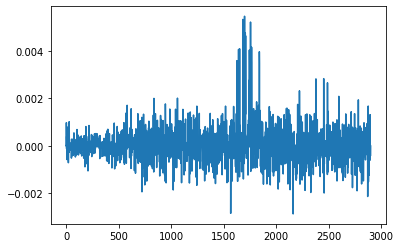

In [40]:
import matplotlib.pyplot as plt
plt.plot(res.x)
print (tau)